# Train recognition model

## Imports

In [2]:
import gc
import re
import json
from tqdm.auto import tqdm
from collections.abc import Callable
from typing import Any

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader

from doctr.models import recognition
from doctr import transforms as T
from torchvision.transforms import v2
import albumentations as A

from torchmetrics.text import CharErrorRate, WordErrorRate

from castom_utils import (load_config,
                          read_json,
                          Ansi, 
                          DeNormalize,
                          save_model,
                          RecognitionDatasetCustom,
                          ColorShiftTorch,
                          ColorShiftAlb,
                          )

In [3]:
CFG = load_config()

Config is loaded!
List of all chars used (114):
0123456789!"'#%&()*+,-./:;<=>?@[\]^_{|}~№°$£€¥¢₽АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя


In [4]:
def draw_image_dataset(
    dataset, 
    normalize_params: dict | None = None, 
    num: int = 16
):
    """
    Вывод нескольких случайных элементов из torch dataset
    """
    length = len(dataset)
    indices = np.random.choice(length, min(num, length))

    if normalize_params is not None:
        denorm = DeNormalize(**normalize_params)

    fig, axes = plt.subplots(num // 2, 2, figsize=(6, num / 2))
    fig.suptitle('augmentation images', fontweight='bold')
    for ax, idx in zip(axes.flat, indices):
        img, target = dataset[idx]

        if normalize_params is not None:
            img = denorm(img)

        img = (img * 255).to(torch.uint8)
        img = img.numpy().transpose(1, 2, 0)
        ax.set_title(target)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

In [5]:
SEED = 42

IS_CUDA = torch.cuda.is_available()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'torch use: {Ansi.green}{Ansi.bold}{DEVICE}{Ansi.end}', 
      f'({torch.cuda.get_device_name()})' 
      if torch.cuda.is_available() else '')

torch use: cuda (AMD Radeon RX 7800 XT)


In [6]:
DATASET = CFG.dataset_synthetic.joinpath('recognition')

BATCH_SIZE = 256

INPUT_SIZE = 32
NORMALIZE_PARAMS = dict(mean=(0.694, 0.695, 0.693), std=(0.299, 0.296, 0.301))

## Dataset

Для обучения модели подготовим два датасета (процесс рассмотрен в ноутбуке **[synthetic_datasets.ipynb](synthetic_datasets.ipynb)**).   
В первом датасете текст будет представлять собой случайный набор символов. Он будет использоваться для первого этапа обучения модели.

Во втором датасете будут преобладать осмысленные слова, в нашем случае взятые из википедии. Изображений со случайным наборов букв в этом датасете будет примерно 10%.

In [11]:
transforms_train_alb = A.Compose([
    A.ShiftScaleRotate(shift_limit=.05, scale_limit=0.0, rotate_limit=0, border_mode=cv2.BORDER_CONSTANT, fill=255, p=.5),
    A.GaussianBlur(blur_limit=(1, 3), p=.3),
    A.RandomSunFlare(flare_roi=(0, 0, 1, 1), src_radius=60, p=.2),
    # A.GaussNoise(std_range=(.1, .25), p=.25),
    # A.ElasticTransform(alpha=40, sigma=50, p=.2),
    # A.ColorJitter(brightness=.4, contrast=.4, saturation=.4, hue=.4, p=.4),
])


transforms_train = v2.Compose([
    v2.ToImage(),
    v2.RandomInvert(p=.1),
    ColorShiftTorch(min_val=.6, p=.9),
    # T.RandomApply(v2.ElasticTransform(alpha=5, sigma=5, fill=255), p=.35),
    T.RandomApply(T.GaussianNoise(mean=0, std=0.15), p=.2),
    v2.RandomPhotometricDistort(brightness=(.7, 1.3), contrast=(.6, 1.4), hue=(-.3, .3), p=.25),
    T.RandomApply(v2.RandomRotation(degrees=2, expand=True), p=.7),
    v2.RandomPerspective(distortion_scale=.2, p=1),
    v2.RandomGrayscale(p=.3),
    T.RandomApply(T.RandomShadow(), p=.2),
    T.Resize((INPUT_SIZE, INPUT_SIZE * 4), interpolation='bilinear', preserve_aspect_ratio=True, symmetric_pad=False),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(**NORMALIZE_PARAMS),
])


transforms_val=v2.Compose([
    v2.ToImage(),
    T.Resize((INPUT_SIZE, INPUT_SIZE * 4), interpolation='bilinear', preserve_aspect_ratio=True, symmetric_pad=False),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(**NORMALIZE_PARAMS),
])

In [10]:
transforms_val

Compose(
      ToImage()
      Resize(output_size=(32, 128), interpolation='bilinear', preserve_aspect_ratio=True, symmetric_pad=False)
      ToDtype(scale=True)
      Normalize(mean=[0.694, 0.695, 0.693], std=[0.299, 0.296, 0.301], inplace=False)
)

In [8]:
train_set1 = RecognitionDatasetCustom(
    DATASET / 'train1',
    transforms_train,
    transforms_train_alb
)

train_set2 = RecognitionDatasetCustom(
    DATASET / 'train2',
    transforms_train,
    transforms_train_alb
)

val_set = RecognitionDatasetCustom(
    DATASET / 'val',
    transforms_val,
)


print(f'train1 size: {len(train_set1)}')
print(f'train2 size: {len(train_set2)}')
print(f'val size:   {len(val_set)}')

train1 size: 200000
train2 size: 1000000
val size:   30000


In [9]:
train_loader1 = DataLoader(
    train_set1,
    batch_size=BATCH_SIZE,
    drop_last=True,
    shuffle=True,
    pin_memory=IS_CUDA,
)

train_loader2 = DataLoader(
    train_set2,
    batch_size=BATCH_SIZE,
    drop_last=True,
    shuffle=True,
    pin_memory=IS_CUDA,
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    drop_last=False,
    shuffle=False,
    pin_memory=IS_CUDA,
)

Примеры получившихся изображений.

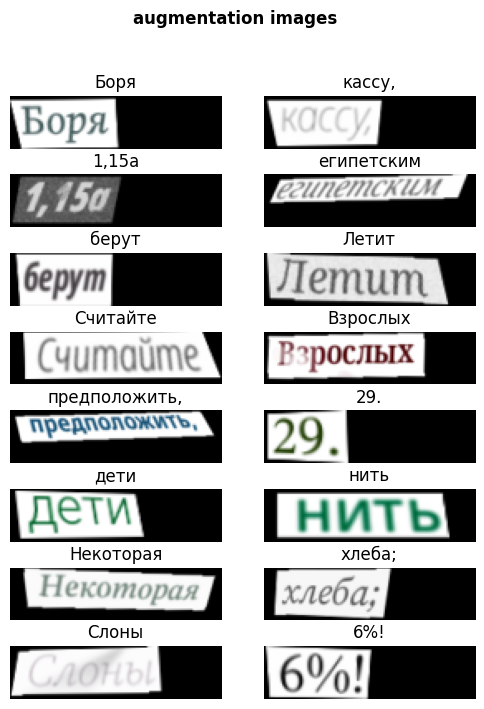

In [10]:
draw_image_dataset(train_set2, NORMALIZE_PARAMS)

## Model initialization

In [11]:
def fit_one_epoch(model, train_loader, optimizer, scheduler, epoch, eposhs):
    model.train()
    train_loss = []
    last_lr = scheduler.get_last_lr()[-1]
    
    pbar = tqdm(train_loader, leave=False)
    for images, targets in pbar:
        images = images.to(DEVICE)
        
        optimizer.zero_grad()
        loss = model(images, targets)['loss']
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

        train_loss.append(loss.detach().item())
        pbar_description = (
            f'Epoch [{epoch + 1}/{eposhs}], lr: {last_lr:.1e}, loss: {np.mean(train_loss):.4f}'
        )
        pbar.set_description(pbar_description)

        # Scheduler step
        scheduler.step()

    return pbar_description


def evaluate(model, val_loader, metric_cer, metric_wer):
    model.eval()
    metric_cer.reset()
    metric_wer.reset()
    val_loss = []
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='evaluation', leave=False)
        for images, targets in pbar:
            images = images.to(DEVICE)
            outputs = model(images, targets, return_preds=True)
            
            val_loss.append(outputs['loss'].item())
            preds = [out[0] for out in outputs['preds']]
    
            metric_cer.update(preds, targets)
            metric_wer.update(preds, targets)

    # Вычисление итоговой метрики
    val_loss = np.mean(val_loss)
    val_cer = metric_cer.compute().item()
    val_wer = metric_wer.compute().item()

    return val_loss, val_cer, val_wer


def main_fit(
    eposhs, 
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    scheduler, 
    metric_cer, 
    metric_wer, 
    exp_name
):
    gc.collect()
    torch.cuda.empty_cache()
    best_metric = best_loss = None
    
    for epoch in range(eposhs):
        # train
        pbar_description = fit_one_epoch(model, train_loader, optimizer, scheduler, epoch, eposhs)
    
        # val
        val_loss, val_cer, val_wer = evaluate(model, val_loader, metric_cer, metric_wer)
    
        # Вывод результатов обучения для эпохи
        print(
            pbar_description, 
            f"| val_loss: {val_loss:.4f},",
            f"CER: {Ansi.bold}{val_cer:.4f}{Ansi.end},",
            f"WER: {Ansi.bold}{val_wer:.4f}{Ansi.end}",
            end = ' '
        )
    
        # Save best model
        if best_metric is None or best_metric > val_cer:
            best_metric = val_cer
            # save_model(model, optimizer, scheduler, CFG.models_save, f'{exp_name}_best_metric')
            print(f'{Ansi.bold}{Ansi.green}metric{Ansi.end}', end = ' ')

        if best_loss is None or best_loss > val_loss:
            best_loss = val_loss
            # save_model(model, optimizer, scheduler, CFG.models_save, f'{exp_name}_best_loss')
            print(f'{Ansi.bold}{Ansi.green}loss{Ansi.end}')
    
        # Save last model
        # save_model(model, optimizer, scheduler, CFG.models_save, f'{exp_name}_last')
        save_model(model, optimizer, scheduler, CFG.models_save, f'{exp_name}_epoch{epoch + 1}')

In [12]:
# Загрузим модель
model = recognition.vitstr_small(pretrained=True, vocab=CFG.vocab).to(DEVICE)

/home/lake/anaconda3/envs/lime/lib/python3.11/site-packages/doctr/models/utils/pytorch.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(archive_p

In [13]:
# Загрузим обученные веса
load_state = torch.load(
    # CFG.models_best.joinpath('best_vitstr_small_1.pth'), 
    CFG.models_save.joinpath('vitstr_exp2_last.pth'),
    map_location=DEVICE, 
    weights_only=True
)
model.load_state_dict(load_state['model'])

<All keys matched successfully>

In [14]:
metric_cer = CharErrorRate()
metric_wer = WordErrorRate()

## Train

Обучение модели на первом наборе данных со случайным набором допустимых символов.

In [14]:
# for p in model.feat_extractor.parameters():
#     p.requires_grad = True

In [15]:
for name, p in model.named_parameters():
    print(name, p.requires_grad)

feat_extractor.0.cls_token True
feat_extractor.0.positions True
feat_extractor.0.projection.weight True
feat_extractor.0.projection.bias True
feat_extractor.1.layer_norm_input.weight True
feat_extractor.1.layer_norm_input.bias True
feat_extractor.1.layer_norm_attention.weight True
feat_extractor.1.layer_norm_attention.bias True
feat_extractor.1.layer_norm_output.weight True
feat_extractor.1.layer_norm_output.bias True
feat_extractor.1.attention.0.linear_layers.0.weight True
feat_extractor.1.attention.0.linear_layers.0.bias True
feat_extractor.1.attention.0.linear_layers.1.weight True
feat_extractor.1.attention.0.linear_layers.1.bias True
feat_extractor.1.attention.0.linear_layers.2.weight True
feat_extractor.1.attention.0.linear_layers.2.bias True
feat_extractor.1.attention.0.output_linear.weight True
feat_extractor.1.attention.0.output_linear.bias True
feat_extractor.1.attention.1.linear_layers.0.weight True
feat_extractor.1.attention.1.linear_layers.0.bias True
feat_extractor.1.atten

In [16]:
parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(parameters, lr=1e-4, weight_decay=.01)

In [16]:
parameters_group = [
    {'params': model.feat_extractor['0'].parameters(), 'lr': 1e-5},
    {'params': model.feat_extractor['1'].parameters(), 'lr': 5e-5},
    {'params': model.head.parameters(), 'lr': 1e-4},
]
optimizer = optim.AdamW(parameters_group, weight_decay=.05)

In [18]:
ratio_lr = .1
num_it = 5000
gamma = (ratio_lr) ** (1 / (num_it - 1))
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda step: gamma)

# optimizer.load_state_dict(load_state['optimizer'])
# scheduler.load_state_dict(load_state['scheduler'])

In [ ]:
main_fit(
    10, 
    model, 
    train_loader2, 
    val_loader, 
    optimizer, 
    scheduler, 
    metric_cer, 
    metric_wer, 
    'vitstr_exp3'
)